In [1]:
magma_dir = '/home/marco/epfl/magma/'
transformers_dir = '/home/marco/epfl/transformers/'

#### AWS

In [ ]:
magma_dir = '/home/ubuntu/magma/'
bucket_dir = '/home/ubuntu/s3/'
transformers_dir = '/home/ubuntu/transformers/'
cache_dir = bucket_dir+'.cache/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

sys.path.insert(0, transformers_dir+'examples/seq2seq/')
import utils

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'fine-tuning/gps_bart_para_wordembed/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

#### AWS

In [ ]:
data_dir = bucket_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
from transformers import EvalPrediction

tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_or_path, df_val,
    min_length, max_length, length_penalty, no_repeat_ngram_size, n_examples=5):
    
    df_examples = df_val.sample(n_examples, axis='index', random_state=config.SEED)
    
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
            
        summ_enc = model.generate(
            tokenizer.encode(row.text, return_tensors='pt', truncation=True).to(device),
            min_length = min_length,
            max_length = max_length,
            length_penalty = length_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size,
            early_stopping = True)[0]
        summ_num_tok = len(summ_enc)
        summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

        print('Prediction\n%s (%d tok):\n'%(model_name_or_path, summ_num_tok))
        print(fill(summ, 100))
        print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Compute Metrics

In [8]:
def compute_metrics(model_name_or_path, df_val,
    min_length, max_length, length_penalty, no_repeat_ngram_size, batch_size=8):
    
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)
    
    summarization_metrics = utils.build_compute_metrics_fn('summarization', tokenizer)

    input_ids = tokenizer(df_val.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)
    
    reference_ids = tokenizer(df_val.bullets.tolist(), return_tensors='pt', padding=True).input_ids
    reference_ids = reference_ids.split(batch_size)
    
    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    metrics_final = {}
    avg_len = len(input_ids)
    
    for batch, label_ids in zip(input_ids, reference_ids):

        pred_ids = model.generate(
            batch.to(device),
            min_length = min_length,
            max_length = max_length,
            length_penalty = length_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size,
            early_stopping = True)
        ep = EvalPrediction(pred_ids, label_ids)
        
        metrics = summarization_metrics(ep)
        for k in metrics.keys():
            if k not in metrics_final:
                metrics_final[k] = 0
            metrics_final[k] += (metrics[k] / avg_len)

        pbar.update(1)
    pbar.close()
    return metrics_final

## **Sentence-Transformers**

In [9]:
data_dir_st = data_dir + 'st/'

In [10]:
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])

### **Generative Parameter Search**

In [11]:
model_name_or_path =  magma_dir+'fine-tuning/ft_bart_para_wordembed/checkpoint-196'

In [12]:
min_length_swipe = [10]#, 20, 30]
max_length_swipe = [110]#, 120, 130]
length_penalty_swipe = [0]#, 1, 2]
no_repeat_ngram_size_swipe = [2]#, 3, 4]

In [13]:
gps_metrics = pd.DataFrame(columns=['min_length', 'max_length', 'length_penalty', 'no_repeat_ngram',
                     'r1_precision', 'r1_recall', 'r1_fmeasure',
                     'r2_precision', 'r2_recall', 'r2_fmeasure',
                     'rL_precision', 'rL_recall', 'rL_fmeasure',
                     'ST', 'W2V'])

In [14]:
idx = 0
for min_length in min_length_swipe:
    for max_length in max_length_swipe:
        for length_penalty in length_penalty_swipe:
            for no_repeat_ngram_size in no_repeat_ngram_size_swipe:
                
                print(''.join(['#']*35))
                print(''.join(['#']*35))
                print('###\t\t\t\t###')
                print('### \tMIN LENGTH: %d\t\t###'%min_length)
                print('### \tMAX LENGTH: %d\t\t###'%max_length)
                print('### \tLENGTH PENALTY: %d\t###'%length_penalty)
                print('### \tNO REPEAT NGRAM: %d\t###'%no_repeat_ngram_size)
                print('###\t\t\t\t###')
                print(''.join(['#']*35))
                print(''.join(['#']*35))
                print()
                
                metrics = compute_metrics(model_name_or_path, df_val,
                    min_length, max_length, length_penalty, no_repeat_ngram_size)
                
                gps_metrics.loc[idx] = [min_length, max_length, length_penalty, no_repeat_ngram_size]+\
                    [metrics[k] for k in metrics if 'sum' not in k and 'len' not in k]
                
                print()
                print_examples(model_name_or_path, df_val,
                    min_length, max_length, length_penalty, no_repeat_ngram_size)

###################################
###################################
###				###
### 	MIN LENGTH: 10		###
### 	MAX LENGTH: 110		###
### 	LENGTH PENALTY: 0	###
### 	NO REPEAT NGRAM: 2	###
###				###
###################################
###################################

100%|██████████| 34/34 [11:09<00:00, 19.68s/it]
(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of the

In [23]:
gps_metrics

,min_length,max_length,length_penalty,no_repeat_ngram,r1_precision,r1_recall,r1_fmeasure,r2_precision,r2_recall,r2_fmeasure,rL_precision,rL_recall,rL_fmeasure,ST,W2V
0,10.0,110.0,0.0,2.0,37.482353,30.350588,32.210294,15.108235,12.411471,13.021176,30.068824,24.55,25.977647,59.699634,46.268111


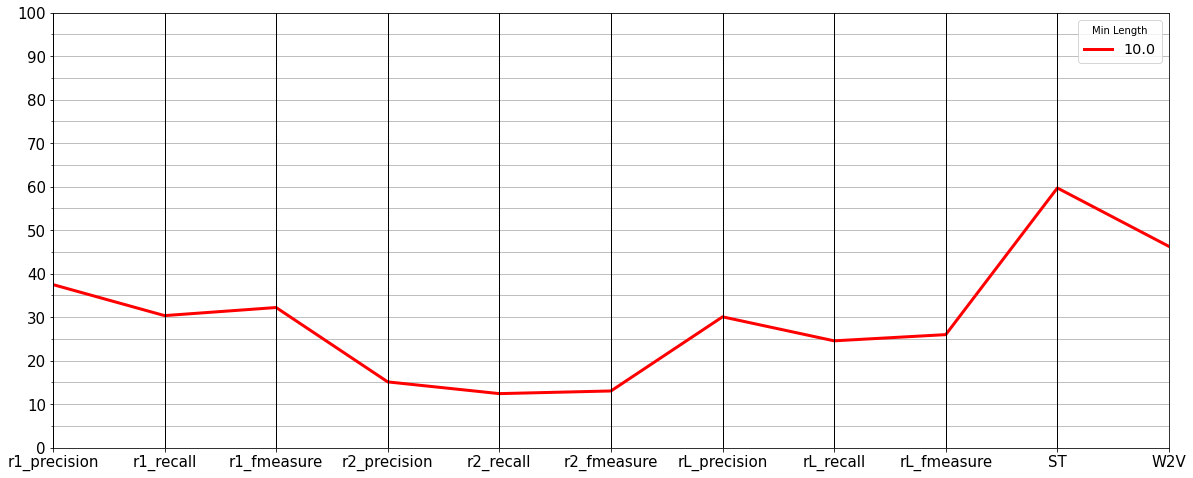

In [75]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
pd.plotting.parallel_coordinates(
    gps_metrics,
    'min_length',
    [c for c in gps_metrics.columns if 'r1' in c or 'r2' in c or 'rL' in c or 'ST' in c or 'W2V' in c],
    ax = ax,
    colormap='hsv',
    linewidth=3,
)
ax.set_yticks(np.linspace(0, 100, 11))
ax.set_yticks(np.linspace(0, 100, 21), minor=True)
for t in ax.xaxis.get_major_ticks():
    t.label.set_fontsize(15)
for t in ax.yaxis.get_major_ticks():
    t.label.set_fontsize(15)
    
ax.grid(True, which='both')

ax.legend(title='Min Length', fontsize='x-large')

plt.show()

#### Summarize Test

In [ ]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary'] = summs
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [ ]:
summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

In [ ]:
summarize(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    df_test, 10)

In [ ]:
summarize(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/',
    df_test, 10)

### **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer

sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

import gensim

#### Evaluate summaries bullet by bullet

In [ ]:
def evaluate_model_bullet_by_bullet(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [ ]:
evaluate_model_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

evaluate_model_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

evaluate_model_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')

#### Evaluate summaries grouping bullets

In [ ]:
def evaluate_model_grouping_bullets(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    df_eval = df_eval.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary': lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['st_cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
    
    def cosine_sim_w2v(s, b):
        s = gensim.utils.simple_preprocess(s, deacc=True)
        b = gensim.utils.simple_preprocess(b, deacc=True)
        corpus = [s, b]
        w2v = gensim.models.Word2Vec(
            corpus,
            min_count=1,
            sg=1,
            seed = config.SEED)
        s_embed = np.mean([w2v.wv[word] for word in s], axis=0)
        b_embed = np.mean([w2v.wv[word] for word in b], axis=0)
        return cosine_sim(s_embed, b_embed)
        
    df_eval['w2v_cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim_w2v(row[1], row[0]), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [ ]:
evaluate_model_grouping_bullets('sshleifer/distilbart-cnn-12-6')

evaluate_model_grouping_bullets(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

evaluate_model_grouping_bullets(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')

#### Plot evaluation bullet by bullet

In [ ]:
plot_evaluation_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

In [ ]:
plot_evaluation_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

In [ ]:
plot_evaluation_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')

#### Plot evaluation grouping bullets

In [ ]:
plot_evaluation_grouping_bullets('sshleifer/distilbart-cnn-12-6')

In [ ]:
plot_evaluation_grouping_bullets(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

In [ ]:
plot_evaluation_grouping_bullets(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')